<a href="https://colab.research.google.com/github/Anteii/HPC-Labs/blob/main/lab4/MassSearch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Notebook setup

In [1]:
from IPython.display import clear_output

In [2]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_21:12:58_PST_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0


In [3]:
!nvidia-smi

Sat Nov 19 16:21:29 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
!git clone https://github.com/NVIDIA/cuda-samples.git
!make -C /content/cuda-samples/Samples/1_Utilities/deviceQueryDrv/
!/content/cuda-samples/bin/x86_64/linux/release/deviceQueryDrv

Cloning into 'cuda-samples'...
remote: Enumerating objects: 11024, done.
remote: Counting objects: 100% (11024/11024), done.
remote: Compressing objects: 100% (1839/1839), done.
remote: Total 11024 (delta 9184), reused 10979 (delta 9159), pack-reused 0
Receiving objects: 100% (11024/11024), 127.03 MiB | 17.20 MiB/s, done.
Resolving deltas: 100% (9184/9184), done.
Checking out files: 100% (3615/3615), done.
make: Entering directory '/content/cuda-samples/Samples/1_Utilities/deviceQueryDrv'
/usr/local/cuda/bin/nvcc -ccbin g++ -I../../../Common  -m64    --threads 0 --std=c++11 -gencode arch=compute_35,code=compute_35 -o deviceQueryDrv.o -c deviceQueryDrv.cpp
nvcc warning : The 'compute_35', 'compute_37', 'compute_50', 'sm_35', 'sm_37' and 'sm_50' architectures are deprecated, and may be removed in a future release (Use -Wno-deprecated-gpu-targets to suppress warning).
/usr/local/cuda/bin/nvcc -ccbin g++   -m64      -gencode arch=compute_35,code=compute_35 -o deviceQueryDrv deviceQueryDrv.

In [5]:
!mkdir src

# Python (CPU)

In [6]:
import numpy as np
np.random.seed(41)

def generate_sub(alphabet, h_min, h_max):
  sub_len = np.random.randint(h_min, h_max, size=1)
  return np.random.choice(alphabet, size=sub_len)

def gen_d(alphabet, subs):
  d = {ch: [] for ch in alphabet}
  for sub_ind, sub in enumerate(subs):
    for ch_ind, ch in enumerate(sub):
      d[ch].append((sub_ind, ch_ind))
  return d

def gen_working_mat(subs, N, H):
  mat = np.array([len(sub) for sub in subs])
  return mat.reshape(-1,1).repeat(H, axis=1)

def iterate(text, d, mat):
  for ind, ch in enumerate(text):
    for pair in d[ch]:
      mat[pair[0], ind - pair[1]] -= 1
  return mat

def is_contain(mat):
  return (mat == 0).any(axis=1)

def find_indices(mat):
  sub_ind, pos_ind = np.where(mat == 0)
  return np.stack([sub_ind, pos_ind]).T

In [7]:
# Define alphabet
S = 6
alphabet = np.arange(0, S, dtype=np.uint8)
# Example
#S = 6
#alphabet = ["a", "b", "c", "d", "e", "f"]

In [8]:
# Define text
H = 100
text = np.random.choice(alphabet, size=H)

# Example
#H = 6
#text = np.array(["a", "a", "e", "f", "e", "d"])

In [9]:
h_min, h_max = 1, 20
N = 10
subs = [generate_sub(alphabet, h_min, h_max) for i in range(N)]

# Example
#N = 3
#subs = [np.array(["a", "a"]), np.array(["a"]), np.array(["f", "e", "d"])]

In [10]:
d = gen_d(alphabet, subs)
mat = gen_working_mat(subs, N, H)

In [11]:
mat = iterate(text, d, mat)

In [12]:
is_contain(mat)

array([False, False, False, False, False,  True, False, False, False,
       False])

In [13]:
find_indices(mat)

array([[ 5,  8],
       [ 5, 10],
       [ 5, 18],
       [ 5, 27],
       [ 5, 32],
       [ 5, 34],
       [ 5, 35],
       [ 5, 47],
       [ 5, 49],
       [ 5, 50],
       [ 5, 53],
       [ 5, 56],
       [ 5, 57],
       [ 5, 66],
       [ 5, 67],
       [ 5, 71],
       [ 5, 76],
       [ 5, 77],
       [ 5, 79],
       [ 5, 80],
       [ 5, 82],
       [ 5, 85],
       [ 5, 86],
       [ 5, 95]])

# C++ (CPU & CUDA)

In [68]:
%%writefile src/gpu.cu
#include <cuda.h>
#include <cuda_runtime.h>
#include <iostream>
#include <vector>
#include <map>
#include <fstream>
#include <string>
#include <chrono>

using namespace std;
using namespace std::chrono;

enum SearchType{
  Indicies,
  Entries
};

enum Device{
  CPU,
  GPU
};

ostream& operator<<(ostream& os, const vector<pair<int, int>>& pairs){
    os << "{";
    for (int i = 0; i < pairs.size(); ++i){
      auto it = pairs[i];
      os << "(" << it.first << ", " << it.second;
      os << (i == pairs.size() - 1 ? ")}" : "), ");
    }

    return os;
}

ostream& operator<<(ostream& os, const vector<bool>& flags){
    os << "{";
    for (int i = 0; i < flags.size(); ++i){
      os << (flags[i] ? "True" : "False");
      os << (i == flags.size() - 1 ? "}" : ", ");
    }

    return os;
}

template<typename T>
void printText(const vector<T>& text, ostream& os){ 
   for (int i = 0; i < text.size(); ++i)
   {
     os << (T)text[i] << (i == text.size() - 1 ? "" : " ");
   }
   os << endl;
}

template<typename T>
void printSubs(const vector<vector<T>>& subs, ostream& os){ 
   for(auto sub : subs){
     printText(sub, os);
   }
}

template <typename T>
vector<int> getSubSizes(const vector<vector<T>>& subs){
  vector<int> subsSizes(subs.size(), 0);
  for (int subInd = 0; subInd < subs.size(); ++subInd){
    subsSizes[subInd] = subs[subInd].size();
  }
  return subsSizes;
}

template <typename T>
map<T, vector<pair<int, int>>> generateDict(const vector<T>& alphabet, const vector<vector<T>>& subs){
  map<T, vector<pair<int, int>>> dict;
  for (auto chr : alphabet){
    dict[chr] = vector<pair<int, int>>();
  }
  
  for (int sub_ind = 0; sub_ind < subs.size(); ++sub_ind){
    auto sub = subs[sub_ind];
    for (int chr_ind = 0; chr_ind < sub.size(); ++chr_ind){
      auto chr = sub[chr_ind];
      dict[chr].push_back({sub_ind, chr_ind});
    }
  }
  
  return dict;
}

vector<vector<int>> generateMatrix(const vector<int>& subsSizes, int textSize){
  vector<vector<int>> mat;
  for (auto subSize : subsSizes){
    mat.push_back(vector<int>(textSize, subSize));
  }
  return mat;
}

template <typename T>
vector<T> generateText(const vector<T>& alphabet, int size){
  vector<T> text(size);
  for (int i = 0; i < size; ++i){
      int ind = rand() % alphabet.size();
      text[i] = alphabet[ind];
  }
  return text;
}

template <typename T>
vector<vector<T>> generateSubs(const vector<T>& alphabet, int n, int sizeMin, int sizeMax){
  vector<vector<T>> subs;

  for (int subInd = 0; subInd < n; ++subInd){
    int size = sizeMin + rand() % (sizeMax - sizeMin + 1); 
    auto sub = generateText(alphabet, size);
    subs.push_back(sub);
  }

  return subs;
}

template <typename T>
float iterateCPU(const vector<T>& text, const map<T, vector<pair<int, int>>>& dict,
            vector<vector<int>>& matrix){
  auto start = high_resolution_clock::now();
  
  for (int chr_ind = 0; chr_ind < text.size(); ++chr_ind){
    for (const auto pair : dict.at(text[chr_ind])){
      if (chr_ind - pair.second > -1){
        //printf("%d\t%d\n", pair.first, chr_ind - pair.second);
        matrix[pair.first][chr_ind - pair.second]--;
      }
    }
  }

  auto end = high_resolution_clock::now();
  auto duration = duration_cast<microseconds>(end - start);
  auto totalTime = duration.count() / 1000.0f;

  return totalTime;
}

void checkError(cudaError_t error){
	if (error != cudaSuccess){
		cout << "Error" << endl;
		cerr << cudaGetErrorString(error) << endl;
    exit(1);
	}
}

// H - length of a text
// N - number of substrings
// C - Alphabet size
template<int blockSize>
__global__ void kernel(int* text, int H, int* matrix, int N, int* dict, int C) {
  int tid = threadIdx.x;
  int i = blockIdx.x * blockSize + tid;

  if (i >= H) return;

  int chr = text[i];

  int offset = 3 * chr;
  int pos = dict[offset + 1];
  int n = dict[offset + 2];

  //if (i == 0){
  // printf("GPU steps\n");
  //}
  

  for (int pair_ind = 0; pair_ind < n; ++pair_ind){
    int ind = pos + pair_ind * 2;
    if (i - dict[ind + 1] > -1){
      //printf("%d\t%d\n", dict[ind], i - dict[ind + 1]);
      atomicSub(matrix + dict[ind] * H + i - dict[ind + 1], 1);
    }
  }
}

// working if char type is int and alphabet is 0..N
__host__ float iterateGPU(const vector<int>& text, const map<int, vector<pair<int, int>>>& dict,
            vector<vector<int>>& matrix){
  
  int textSize = text.size();
  int N = matrix.size();
  int H = matrix[0].size();
  int alphabetSize = dict.size();
  int entryNumber = 0;
  float totalTime = 0;

  // Flatten map [(char, offset, n)][(sub_ind, pos_ind)]
  vector<int> dictHost;

  int curPos = 0;
  for (auto it : dict){
    dictHost.push_back(it.first);
    dictHost.push_back(3 * alphabetSize + entryNumber * 2);
    dictHost.push_back(it.second.size());

    entryNumber += it.second.size();
  }

  // Temporary memory for flat pairs
  int* flatPairs = new int[2 * entryNumber];

  for (auto it : dict){
    // Copy map data to a device [(sub_ind, pos_ind)]
    for (auto pair : it.second){
      flatPairs[curPos++] = pair.first;
      flatPairs[curPos++] = pair.second;
    }
  }

  int dictDeviceSize = 3 * alphabetSize + 2 * entryNumber;
  
  // Device pointers
  int* textDevice;
  int* matrixDevice;
  int* dictDevice; // [(char, offset, n)][(sub_ind, pos_ind)]
  
  // Copy text to a device
  checkError(cudaMalloc(&textDevice, textSize * sizeof(int)));
  checkError(cudaMemcpy(textDevice, &text[0], textSize * sizeof(int), cudaMemcpyHostToDevice));

  // Flatten and copy matrix to a device
  checkError(cudaMalloc(&matrixDevice, N * H * sizeof(int)));
  for (int sub_ind = 0; sub_ind < N; ++sub_ind){
    checkError(cudaMemcpy(matrixDevice + sub_ind * H, &matrix[sub_ind][0], textSize * sizeof(int), cudaMemcpyHostToDevice));
  }

  // Copy meta part of map to a device [(char, offset, n)]
  checkError(cudaMalloc(&dictDevice, dictDeviceSize * sizeof(int)));
  checkError(cudaMemcpy(dictDevice, &dictHost[0], 3 * alphabetSize * sizeof(int), cudaMemcpyHostToDevice));
  
  checkError(cudaMemcpy(dictDevice + 3 * alphabetSize, flatPairs, 2 * entryNumber * sizeof(int), cudaMemcpyHostToDevice));

  const int blockX = 512;
  const int gridX = int(1.0f * (textSize - 1) / blockX) + 1;

  cudaEvent_t startEvent, stopEvent;
  checkError(cudaEventCreate(&startEvent));
  checkError(cudaEventCreate(&stopEvent));
  
  checkError(cudaEventRecord(startEvent, 0));

  kernel<blockX><<<gridX, blockX>>>(textDevice, textSize, matrixDevice, N, dictDevice, alphabetSize);

  checkError(cudaEventRecord(stopEvent, 0));

  checkError(cudaDeviceSynchronize());
  checkError(cudaEventElapsedTime(&totalTime, startEvent, stopEvent));

  for (int i = 0; i < N; ++i){
    checkError(cudaMemcpy(&matrix[i][0], (matrixDevice + i * H), H * sizeof(int), cudaMemcpyDeviceToHost));
  }

  delete[] flatPairs;
  cudaFree(matrixDevice);
  cudaFree(textDevice);
  cudaFree(dictDevice);

  return totalTime;
}

vector<pair<int, int>> findIndices(const vector<vector<int>>& mat){
  vector<pair<int, int>> result;

  int textSize = mat[0].size();

  for (int subInd = 0; subInd < mat.size(); ++subInd){
    for (int textPos = 0; textPos < textSize; ++textPos){
      if (mat[subInd][textPos] == 0){
        result.push_back({subInd, textPos});
      }
    }
  }

  return result;
}

vector<bool> findEntries(const vector<vector<int>>& mat){
  
  vector<bool> result(mat.size(), false);
  int textSize = mat[0].size();

  for (int subInd = 0; subInd < mat.size(); ++subInd){
    for (int textPos = 0; textPos < textSize; ++textPos){
      if (mat[subInd][textPos] == 0){
        result[subInd] = true;
        break;
      }
    }
  }

  return result;
}

bool checkEquality(const vector<vector<int>>& mat1, const vector<vector<int>>& mat2){
  for (int i = 0; i < mat1.size(); ++i){
    for (int j = 0; j < mat1[0].size(); ++j){
      if (mat1[i][j] != mat2[i][j]){
        return false;
      }
    }
  }
  return true;
}

int cumDiv(const vector<vector<int>>& mat1, const vector<vector<int>>& mat2){
  int c = 0;
  for (int i = 0; i < mat1.size(); ++i){
    for (int j = 0; j < mat1[0].size(); ++j){
      if (mat1[i][j] != mat2[i][j]){
        c++;
        //printf("i=%d j=%d\n", i, j);
      }
    }
  }
  return c;
}

void experiment(int textSize, int subN, int subSizeMin, 
            int subSizeMax, SearchType searchType){
  ofstream myfile;
  myfile.open ("data.txt");

  float cpuTime = 0.0f;
  float gpuTime = 0.0f;

  // Generate 8bit alphabet

  int alphabetSize = 256;
  vector<int> alphabet(alphabetSize);
  for (int i = 0; i < alphabetSize; ++i){
    alphabet[i] = i;
  }

  // Generate text
  vector<int> text = generateText<int>(alphabet, textSize);
  // Generate substrings
  auto subs = generateSubs<int>(alphabet, subN, subSizeMin, subSizeMax);
  vector<int> subsSizes = getSubSizes<int>(subs);
  
  int c = 0;
  for (int i = 0; i < subsSizes.size(); ++i){
    c += subsSizes[i];
  }
  cout << c << endl;
  
  // Preliminary step
  map<int, vector<pair<int, int>>> dict = generateDict<int>(alphabet, subs);
  vector<vector<int>> mat1 = generateMatrix(subsSizes, textSize);
  vector<vector<int>> mat2 = generateMatrix(subsSizes, textSize); // copy

  // Save input data
  myfile << textSize << " " << subN << " " <<  subSizeMin << " "
     << subSizeMax << " " << searchType << endl;
  printText(alphabet, myfile);
  printText(text, myfile);
  printSubs(subs, myfile);

  /*
  printText<int>(text, cout);

  printf("Original matrix\n");
  for (int i = 0; i < mat1.size(); ++i){
    for (int j = 0; j < mat1[0].size(); ++j){
      cout << mat1[i][j] << "\t";
    }
    cout << endl;
  }
  */

  // CPU
  cpuTime = iterateCPU<int>(text, dict, mat1);
  

  int* a;
  checkError(cudaMalloc(&a, 1 * sizeof(int)));
  checkError(cudaFree(a));
  
  // CUDA
  gpuTime = iterateGPU(text, dict, mat2);

  cout << "CPU time: " << cpuTime << "ms" << endl;
  cout << "GPU time: " << gpuTime << endl;

  // Check equality
  if (checkEquality(mat1, mat2)){
    cout << "Correct!" << endl;
  }
  else{
    cout << "Incorect! " << cumDiv(mat1, mat2) << " errors" << endl;
  }

  /*
  printf("CPU final matrix\n");
  for (int i = 0; i < mat1.size(); ++i){
    for (int j = 0; j < mat1[0].size(); ++j){
      cout << mat1[i][j] << "\t";
    }
    cout << endl;
  }
  cout << endl << endl;
  printf("GPU final matrix\n");
  for (int i = 0; i < mat1.size(); ++i){
    for (int j = 0; j < mat1[0].size(); ++j){
      cout << mat2[i][j] << "\t";
    }
    cout << endl;
  }
  */
  
  // Interpret results
  switch(searchType){
    case Indicies:{
      vector<pair<int, int>> indices = findIndices(mat1);
      myfile << indices << endl;
    }
    break;
    case Entries:{
      vector<bool> entries = findEntries(mat1);
      myfile << entries << endl;
      break;
    } 
  }
  myfile.close();
}

int main(int argc, char** argv){
  srand(42);

  // For some reason doesn't work if don't make cuda call in main/experiment functions
  int* a;
  checkError(cudaMalloc(&a, 1 * sizeof(int)));
  checkError(cudaFree(a));

  // Parse command line arguments
  int textSize = stoi(argv[1]);
  int subN = stoi(argv[2]);
  int subSizeMin = stoi(argv[3]);
  int subSizeMax = stoi(argv[4]);
  SearchType searchType = (SearchType)stoi(argv[5]);

  // Run experiment
  experiment(textSize, subN, subSizeMin, subSizeMax, searchType);

  return 0;
}

Overwriting src/gpu.cu


In [69]:
!nvcc src/gpu.cu -o gpu

In [93]:
# textSize subN subSizeMin subSizeMax searchType(0 - inds, 1 - entry)
!./gpu 10000 10000 1 10000 0

49871937
CPU time: 93593ms
GPU time: 1291.41
Correct!


# Vizualization

In [87]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

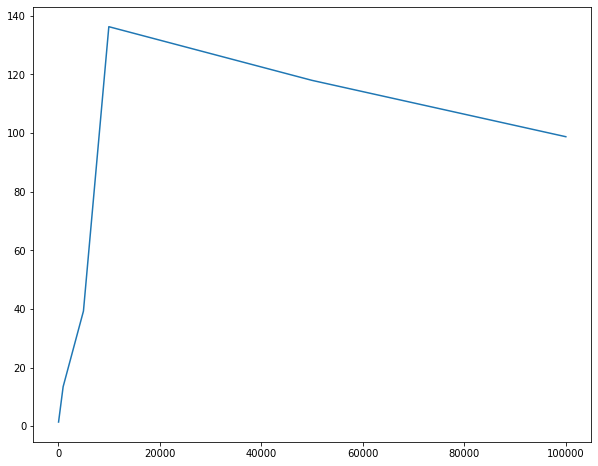

In [88]:
text_sizes = [100, 1000, 5000, 10000, 50000, 100000]
sub_N = [10, 10, 10, 10, 10, 10]

cpu_times = np.array([0.037, 0.727, 11.07, 54.911, 794.426, 6076.96])
gpu_times = np.array([0.026, 0.054, 0.282, 0.403, 6.735, 61.551])
speed_up = cpu_times / gpu_times

_, ax = plt.subplots(figsize=(10, 8))

sns.lineplot(x=text_sizes, y=speed_up, ax=ax);

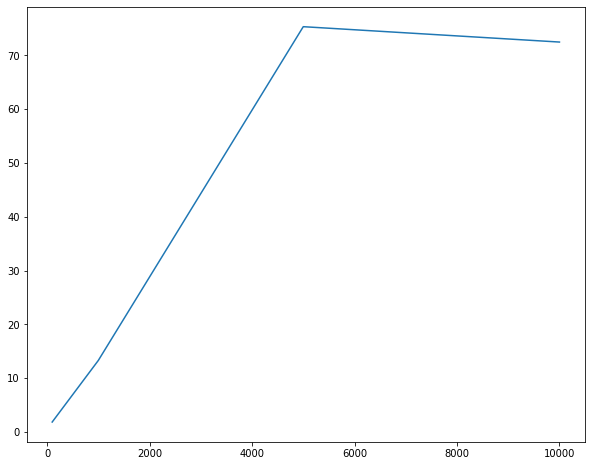

In [94]:
text_sizes = [100, 1000, 5000, 10000]
sub_N = [100, 1000, 5000, 10000]

cpu_times = np.array([0.064, 46.402, 10099.8, 93593])
gpu_times = np.array([0.035, 3.495, 134.074, 1291.41])

speed_up = cpu_times / gpu_times

_, ax = plt.subplots(figsize=(10, 8))

sns.lineplot(x=text_sizes, y=speed_up, ax=ax);